## Basic optimization calculation protocol

At room temperature, most molecules will be in their ground state (i.e., minimum energy state). In terms of molecular structure this means the state where the atoms are arranged such that the total (i.e., nuclear + electronic) energy is lowest. The structure that you get of your molecule from Avogadro has not been optimized using quantum mechanical equations based on the wave functions of all the electrons and is likely far from the ground state. This means that some of the bond distances and angles need to be adjusted before we can perform other quantum mechanical calculations on these molecules. To do this, we choose our basis set and calculate the energy of the initial molecule using the Hartree-Fock method. Then, the atom positions are adjusted to decrease the energy, and the calculation is performed again. To determine how to adjust the atom positions, one strategy is to look for the adjustment that will decrease the energy the most with a small change. This can be thought of like moving in the steepest descent direction on a free energy surface, as shown in the figure. To find the steepest descent direction, a gradient (derivative) of the energy is calculated, and the adjustment is made in the direction of the most negative gradient. Other more advanced optimization methods that converge more quickly and are more accurate include the conjugate gradient method and quasi-Newton methods like BFGS (which use approximations of the Hessian/matrix of second derivatives). This process is repeated until the energy has reached a minimum and the gradient is zero. Now you have an optimized geometry for your molecule!

## Optimizing benzene

To demonstrate a geometry optimization, let’s use the PsiAPI to create a benzene molecule. In this example, we have generated coordinates using Avogadro, but you could generate stating coordinates with any molecular visualization program.

First, import the python packages you will use.

In [1]:
# import the python modules that we will use
import psi4
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

### Setting up the molecule

First we will set up our molecule as an object in Psi4 using the function `psi4.geometry()`. Once we have the molecule built, we can use Psi4 to calculate different attributes of the molecule using the basis set that we specify. In this case we will use the Hartree-Fock method (SCF) and the cc-pVDZ basis set. We will calculate the energy of the molecule and print it to a file called ‘energy_initial’, since this is the initial structure of our molecule. It turns out that this command gives us more than just the molecule’s energy.

We can also print the positions of all the atoms at any time using `molecule.print_out_in_angstrom()` and all of the interatomic distances using `molecule.print_distances()`. We will print these to a file called ‘geometry_initial’ as an example of Psi4’s functionality, but we don’t really need this information right now.

In [2]:
# set the amount of memory you will need
psi4.set_memory('2 GB')

# set the number of threads (processes) for Psi4 to use
# (my HP-6300 PC could handle 4 threads)
psi4.set_num_threads(4)

# set the molecule name for your files and plots
molecule_name = "benzene"

# enter the charge, multiplicity, and starting coordinates of the atoms in your molecule
benzene = psi4.geometry("""
0 1
   C       -3.98116        3.81771        0.00000
   C       -2.63351        3.75967        0.10838
   C       -2.11978        2.80187       -0.29323
   C       -2.68901        1.83558       -0.80805
   C       -3.92704        1.83138       -0.93484
   C       -4.58021        2.71451       -0.58263
   H       -4.52562        4.63006        0.32966
   H       -2.09025        4.53029        0.52795
   H       -1.09209        2.75239       -0.21305
   H       -2.13621        1.02769       -1.13476
   H       -4.38300        1.01321       -1.36811
   H       -5.60487        2.68217       -0.70124
""")

In [3]:
# calculate the initial energy of the molecule using the Hartree-Fock method
# and the cc-pVDZ basis set; print this output to a file
psi4.set_output_file(molecule_name + '_energy_initial.dat', False)
psi4.energy('scf/cc-pVDZ')

-230.4778160948724

In [4]:
psi4.set_output_file(molecule_name + '_geometry_initial.dat', False)
benzene.print_out_in_angstrom()
benzene.print_distances()

### Geometry optimization

Now that we have the molecule setup, we will perform the geometry optimization. The `psi4.optimize()` function performs the optimization, and we need to tell it what method (SCF) and basis set (cc-pVDZ) to use and what molecule to optimize. As the optimization runs, information will be printed to the ‘geometry_optimization’ file at each step.

**Note:** Although Psi4’s default settings should work fine for most reasonable starting geometries, you may need to modify the maximum number of SCF iterations and/or the maximum number of geometry optimization iterations. To modify the maximum number of SCF interations (e.g., to 500), we can do so with `psi4.set_module_options('scf', {'maxiter': 500})`. Similarly, to modify the maximum number of geometry optimization iterations (e.g., to 100), we can do so with `psi4.set_options({'geom_maxiter': 100})`.

After the optimization is complete, we print the atomic coordinates and interatomic distances again, to the ‘geometry_final’ file.

In [5]:
# optimize the molecular geometry
psi4.set_output_file(molecule_name + '_geometry_optimization.dat', False)
psi4.optimize('scf/cc-pVDZ', molecule=benzene)

Optimizer: Optimization complete!


-230.7219256679512

In [6]:
# print the optimized atomic coordinates and interatomic distances
psi4.set_output_file(molecule_name + '_geometry_final.dat', False)
benzene.print_out_in_angstrom()
benzene.print_distances()

### Reading bond distances from the geometry optimization file

Below is a function that will pull out the bond distances for any two atoms in the molecule from the geometry optimization output file. This way you can look at how the bond distances change during the optimization process. We won’t explain how the function works here, but you can see the information in the ‘geometry_optimization’ file in the lines that begin with R(a,b), where a and b are the numbers for the two atoms that form a bond.

In [7]:
# function to find the bond distance for two specific atoms in the optimization file
def plot_R(a,b):
    with open(molecule_name + '_geometry_optimization.dat') as f:
        pair_notation = 'R(' + str(a) + ',' +str(b) + ')'
        rows_with_R_pairs = [line.split() for line in f if line.find(pair_notation) > 1 and
                             line.strip().split()[1].startswith(pair_notation)]
        
        bond_distances = []
        bond_distances.append(float(rows_with_R_pairs[0][3]))
        
        for item in rows_with_R_pairs:
            bond_distances.append(float(item[6]))
        
        return bond_distances

### Plotting how bond distances change during optimization

Using the function above, we will find the bond distances between two atoms at each step of the optimization and store them in the list bond_distances. We also need to find what the largest and smallest values of the bond distance are during optimization so that we know what range to use for plotting on the y-axis.

Then, we will plot how that distance changes at each step of the optimization process. You should see it change from the initial value and then level out to the optimal bond distance based on the Hartree-Fock method and the cc-pVDZ basis set.

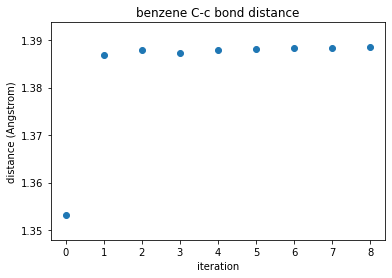

In [8]:
# find the bond distance for atoms C1 and C2
bond_distances = plot_R(1, 2)
# determine an appropriate range for plotting
dist_range = max(bond_distances) - min(bond_distances)

# plot the bond distances at each iteration of geometry optimization
plt.scatter(np.arange(len(bond_distances)), bond_distances)
plt.ylim(top = max(bond_distances) + dist_range*0.15,
         bottom = min(bond_distances) - dist_range*0.15)
plt.xlabel("iteration")
plt.ylabel("distance (Angstrom)")
plt.title(molecule_name + " C-c bond distance")
plt.show()

### Reading energies from the geometry optimization file

Below is a function that will extract the molecular energies from the geometry optimization output file. This way you can look at how the energy changes during the optimization process. In the ‘geometry_optimization’ file you can find this information on lines that begin with **Current energy**.

In [9]:
# function to find the energy in the optimization file
def plot_energy():
    with open(molecule_name + '_geometry_optimization.dat') as f:
        # energy_string = 'Current energy'
        energy_values = [ float(line.split()[3]) for line in f if line.strip().startswith('Current energy') ]
        return energy_values

### Plotting how energy changes during optimization

Using the function above, we will find the molecule’s energy at each step of the optimization and store them in the list `energy_values`.

Then, we will plot how the energy changes at each step of the optimization process. What trend do you expect to see? Why?

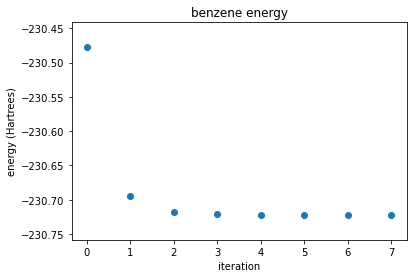

In [10]:
# find the energies from this optimization file
energy_values = plot_energy()

# determine an appropriate range for plotting
energy_range = max(energy_values) - min(energy_values)

# plot the energies at each iteration
plt.figure()
plt.scatter(np.arange(len(energy_values)), energy_values)
plt.ylim(top = max(energy_values) + energy_range*0.15,
         bottom = min(energy_values) - energy_range*0.15)
plt.xlabel("iteration")
plt.ylabel("energy (Hartrees)")
plt.title(molecule_name + " energy")

# savefig after show doesn't work, because show will close the plt instance
plt.savefig(F'benzene_energy.png')
plt.show()

## Exercise: Nitrobenzene

Using the commands you learned above, perform a geometry optimization for nitrobenzene. You may wish to make a copy of the notebook you have made so far and change the relevant portions. You will need to generate coordinates for nitrobenzene using Avogadro or another molecular drawing program. Plot the distance between the C-N bond as a function of iteration. Plot the energy of the molecule as a function of iteration.

In [58]:
from rdkit.Chem import AllChem
nitrobenzene = AllChem.MolFromSmiles('c1ccc(cc1)[N+](=O)[O-]')
nitrobenzene = AllChem.AddHs(nitrobenzene)
nitrobenzene.SetProp('_Name', '0 1')
AllChem.EmbedMolecule(nitrobenzene)
nitrobenzene_geometry = AllChem.MolToXYZBlock(nitrobenzene)
print(nitrobenzene_geometry)

14
0 1
C      1.915500    0.002049    0.088372
C      1.218970   -1.190330    0.074062
C     -0.159190   -1.138400    0.009682
C     -0.874428    0.025354   -0.040737
C     -0.172324    1.210649   -0.026066
C      1.209295    1.187050    0.038054
N     -2.294889   -0.008933   -0.105777
O     -2.977381    1.032849   -0.152845
O     -2.951167   -1.212359   -0.118069
H      2.996131    0.030618    0.137819
H      1.777346   -2.114712    0.113662
H     -0.687920   -2.101430   -0.000314
H     -0.743587    2.138844   -0.066317
H      1.743643    2.138751    0.048474



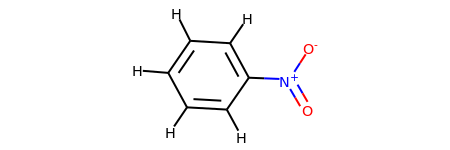

In [45]:
nitrobenzene

In [59]:
N = nitrobenzene.GetAtomWithIdx(6)
print(N.GetSymbol())

N


In [60]:
[print(atom.GetIdx(), atom.GetSymbol()) for atom in N.GetNeighbors()]

print('Discover the index of C atom bonded with N.')

3 C
7 O
8 O
Discover the index of C atom bonded with N.


In [62]:
molecule_name = 'nitrobenzene'

nitrobenzene_psi4_geometry = psi4.geometry(nitrobenzene_geometry)
psi4.set_output_file(molecule_name + '_geometry_optimization.dat', False)
psi4.optimize('scf/cc-pVDZ', molecule=nitrobenzene_psi4_geometry)

psi4.set_output_file(molecule_name + '_geometry_final.dat', False)
nitrobenzene_psi4_geometry.print_out_in_angstrom()
nitrobenzene_psi4_geometry.print_distances()

Optimizer: Optimization complete!


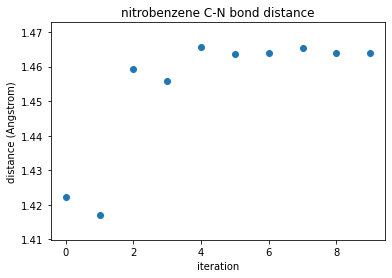

In [63]:
bond_distances = plot_R(4, 7)

dist_range = max(bond_distances) - min(bond_distances)

plt.scatter(np.arange(len(bond_distances)), bond_distances)
plt.ylim(top = max(bond_distances) + dist_range*0.15,
         bottom = min(bond_distances) - dist_range*0.15)
plt.xlabel("iteration")
plt.ylabel("distance (Angstrom)")
plt.title(molecule_name + " C-N bond distance")
plt.show()

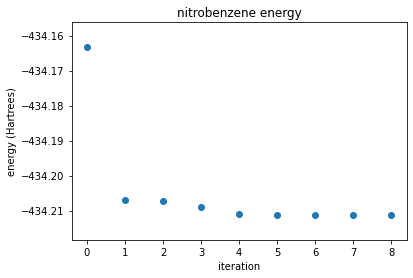

In [64]:
energy_values = plot_energy()

energy_range = max(energy_values) - min(energy_values)

plt.figure()
plt.scatter(np.arange(len(energy_values)), energy_values)
plt.ylim(top = max(energy_values) + energy_range*0.15,
         bottom = min(energy_values) - energy_range*0.15)
plt.xlabel("iteration")
plt.ylabel("energy (Hartrees)")
plt.title(molecule_name + " energy")

plt.savefig(F'nitrobenzene_energy.png')
plt.show()